This notebook is meant for summarizing my research results, specifically for algorithms that use an explicit clustering of neurons into K classes, and based on GLMs

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline

Section 1: Assign cell classes based on brain region, corical layer, and inh/exc

Text(0.5,0,'neuron')

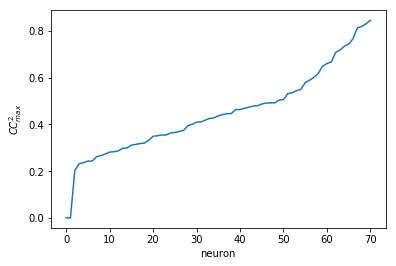

In [2]:
# cell type information on VISp neurons from 1 mouse
D = np.load('cell_types71.npz')
cell_types = D['cell_types']

# drifting grating stimuli and response data
D = np.load('drifting_gratings_data.npz')
binned_spikes = D['binned_spikes']
stim = D['stim_array']
CCmaxs = D['CCmaxs']
bin_len = 0.01
plt.plot(np.square(np.sort(CCmaxs)))
plt.ylabel('$CC_{max}^2$')
plt.xlabel('neuron')

In [3]:
#these are the cells (and corresponding cell types) that I preselected based on their CCmax values
ord_idxs = np.argsort(CCmaxs)[-30:]
ord_idxs = np.concatenate((ord_idxs[:-12],ord_idxs[-11:-6],ord_idxs[-5:]))
ord_types = cell_types[ord_idxs] 

types,counts = np.unique(cell_types[ord_idxs],return_counts=True)
print 'unique types: ', types
print 'frequencies:', counts

unique types:  ['exc_VISp_1' 'exc_VISp_5' 'inh_VISp_1' 'inh_VISp_4' 'inh_VISp_5']
frequencies: [ 3  3  4  2 16]


In [4]:
#helper functions for fitting GLM models
def construct_Xdsn(flat_stimulus, binned_spikes, d):
    (N,T) = binned_spikes.shape # N is number of neurons, T is number of time bins
    (M,T1) = flat_stimulus.shape # M is the size of a stimulus
    assert T==T1, "arrays have different number of time samples"
    X_dsn = np.ones((T-d,M+N*d+1))
    for t in range(T-d):
        X_dsn[t,:M] = flat_stimulus[:,t+d].reshape((1,-1))  #stimulus inputs
    for t in range(T-d):
        X_dsn[t,M:-1] = np.fliplr(binned_spikes[:,t:t+d]).reshape((1,-1)) #spike inputs
    return X_dsn

def fit_GLM(stim,spks,d):
    model =  sm.GLM(spks[0,d:],construct_Xdsn(stim,spks,d),family = sm.families.Poisson())
    model_results = model.fit()
    p = model_results.params
    se = model_results.bse
    b = p[-1]
    bse = se[-1]
    stim_filt = p[:-1-d]
    stim_se = se[:-1-d]
    spk_filt = p[-1-d:-1]
    spk_se = se[-1-d:-1]
    normnegloglike = -model_results.llf/(spks.shape[-1]-d)
    return stim_filt, spk_filt, b, stim_se, spk_se, bse, normnegloglike

def val_GLM(stim,spks,d,stim_filt,spk_filt,b):
    model =  sm.GLM(spks[0,d:],construct_Xdsn(stim,spks,d),family = sm.families.Poisson())
    return -model.loglike(np.concatenate((stim_filt,spk_filt,np.expand_dims(b,0))))/(spks.shape[-1]-d)

In [5]:
#expand the stimulus representation to a 1-hot encoding for combinations of experimental variables
conds = np.unique(stim,axis=1)  
mod_stim = np.zeros((conds.shape[1],stim.shape[1]))
for t in range(stim.shape[1]):
    ind = np.argwhere(np.all(stim[:,t:t+1]-conds==0,axis=0))
    mod_stim[ind,t] = 1

In [6]:
d=30
stim_filt, spk_filt, b, stim_se, spk_se, bse, nnll = fit_GLM(mod_stim,np.expand_dims(binned_spikes[ord_idxs[-1],:],0),d)

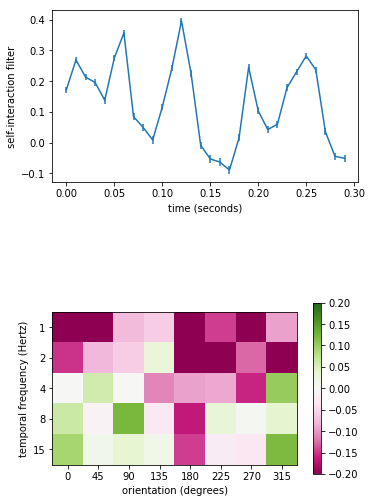

In [7]:
fig,(ax1,ax2) = plt.subplots(nrows=2,)
ax1.errorbar(np.arange(d)*bin_len,spk_filt,yerr=spk_se)
ax1.set_ylabel('self-interaction filter')
ax1.set_xlabel('time (seconds)')
im=ax2.imshow(stim_filt[1:].reshape(5,8),cmap='PiYG',vmin=-0.2,vmax=0.2)
fig.colorbar(im,ax=ax2)
ax2.set_yticks(range(5))
ax2.set_yticklabels(np.unique(stim[0,:])[1:])
ax2.set_ylabel('temporal frequency (Hertz)')
ax2.set_xticks(range(8))
ax2.set_xticklabels(np.unique(stim[2,:])[1:])
ax2.set_xlabel('orientation (degrees)')
fig.tight_layout()
fig.set_size_inches(5,h=8)

From the stimulus filter, you can see that the cell prefers high frequency stimuli, with an orientation near 0 degrees. However, because I'm just specifying the condition and not providing temporal information, the preference for 15Hz stimuli is encoded in the self-interaction filter. I've tried to avoid this by providing inputs that are sinusoids of the appropriate frequencies, and I think phases, but I don't know enough about the stimuli (multiplexed with the 1-hot encoding), but this does not seem to help.

(0, 1)

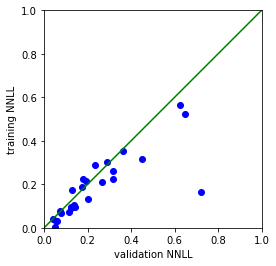

In [8]:
#these are the results from fitting the 30 cells with the highest CCmax
results_sm = np.load('drifting_gratings_indivfit1.npz') #fitted using statsmodels code above
lims = [0,1]
plt.plot(results_sm['val_nnlls'],results_sm['train_nnlls'],'bo')
plt.ylabel('training NNLL')
plt.xlabel('validation NNLL')
plt.plot(lims,lims,'g')
plt.axis('square')
plt.xlim(lims)
plt.ylim(lims)

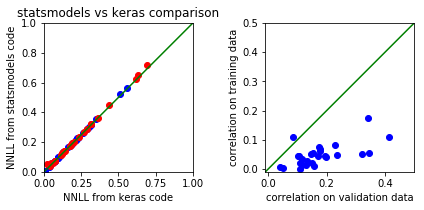

In [9]:
# here, I'm comparing to the result I get with my keras code (too unweildy for this doc)
results_ker = np.load('drifting_gratings_indivfit1_keras.npz') #fitted using keras code
lims = [0,1]
fig,(ax1,ax2) = plt.subplots(ncols=2)
ax1.plot(results_ker['train_losses'],results_sm['train_nnlls'],'bo')
ax1.plot(results_ker['val_losses'],results_sm['val_nnlls'],'ro')
ax1.plot(lims,lims,'g')
ax1.axis('square')
ax1.set_xlim(lims)
ax1.set_ylim(lims)
ax1.set_ylabel('NNLL from statsmodels code')
ax1.set_xlabel('NNLL from keras code')
ax1.set_title('statsmodels vs keras comparison')

lims = [-0.01,0.5]
ax2.plot(results_ker['val_corrs'],results_ker['train_corrs'],'bo')
ax2.plot(lims,lims,'g')
ax2.axis('square')
ax2.set_xlim(lims)
ax2.set_ylim(lims)
ax2.set_ylabel('correlation on training data')
ax2.set_xlabel('correlation on validation data')
fig.tight_layout()

The comparison seems pretty good - one thing this isn't showing however, is one cell that had an infinite loss using statsmodels, and a fairly normal one using keras. In my understanding, the main difference is that sm uses an IRLS solver, and keras uses gradient descent.

The correlation measure to me is confusing - the validation score should never be better. I suspect it may have something to do with my split of the dataset - there are three 60-second periods of drifting gratings, interspersed with two 100-second periods of a grey screen. Exactly how much of each I pick might make the validation data easier to predict; or it could  have to do with latent states affecting the spiking.

I have been working on the shared parameters model, but the design matrix for a GLM solver grows in size with the number of cells, squared. This is causing problems for the statsmodels GLM solver, so I've been trying to get it working for very small sizes so that I can compare to my keras solver (for shared parameters), which gets around building the full design matrix.

Below, the the losses for the shared vs independent parameter models are compared

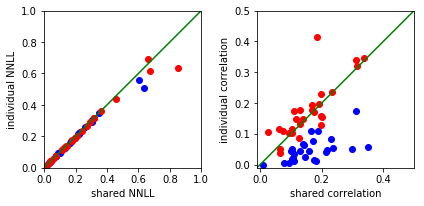

In [21]:
results_shared = np.load('driftinggs_shared_run1.npz') #fitted using statsmodels code above

lims = [0,1]
fig,(ax1,ax2) = plt.subplots(ncols=2)
ax1.plot(results_shared['train_losses'],results_ker['train_losses'],'bo')
ax1.plot(results_shared['val_losses'],results_ker['val_losses'],'ro')
ax1.plot(lims,lims,'g')
ax1.axis('square')
ax1.set_xlim(lims)
ax1.set_ylim(lims)
ax1.set_xlabel('shared NNLL')
ax1.set_ylabel('individual NNLL')

lims = [-0.01,0.5]
ax2.plot(results_shared['train_corrs'],results_ker['train_corrs'],'bo')
ax2.plot(results_shared['val_corrs'],results_ker['val_corrs'],'ro')
ax2.plot(lims,lims,'g')
ax2.axis('square')
ax2.set_xlim(lims)
ax2.set_ylim(lims)
ax2.set_xlabel('shared correlation')
ax2.set_ylabel('individual correlation')
fig.tight_layout()

Below, I contrast with a model that has no self-interaction filter. It seems fairly clear that the filter improves performance, especially generalizability

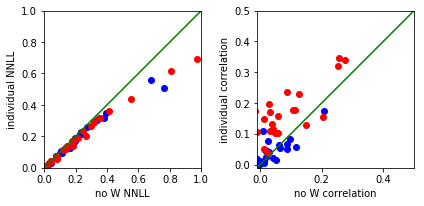

In [22]:
results_noW = np.load('driftinggs_noW_run1.npz') #fitted using statsmodels code above

lims = [0,1]
fig,(ax1,ax2) = plt.subplots(ncols=2)
ax1.plot(results_noW['train_losses'],results_ker['train_losses'],'bo')
ax1.plot(results_noW['val_losses'],results_ker['val_losses'],'ro')
ax1.plot(lims,lims,'g')
ax1.axis('square')
ax1.set_xlim(lims)
ax1.set_ylim(lims)
ax1.set_xlabel('no W NNLL')
ax1.set_ylabel('individual NNLL')

lims = [-0.01,0.5]
ax2.plot(results_noW['train_corrs'],results_ker['train_corrs'],'bo')
ax2.plot(results_noW['val_corrs'],results_ker['val_corrs'],'ro')
ax2.plot(lims,lims,'g')
ax2.axis('square')
ax2.set_xlim(lims)
ax2.set_ylim(lims)
ax2.set_xlabel('no W correlation')
ax2.set_ylabel('individual correlation')
fig.tight_layout()